### Finding RGB channel normalisation params

In [2]:
# Get pixel data
# Random sample
# Extract and print channel means and std_dev 
# (across images, we need avg std dev within a given cell image across images, 
# avg channel value in image across images)

# We always normalise last, for obvious reasons, if you're using saturation 
# or any sort of colour augmentation normalisation gets fucked

In [17]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from skimage.transform import resize
import os

CHANNELS = ['red', 'green', 'blue', 'yellow']
TRAIN_CSV = '../input/train_cells/train.csv'
img_dir = '../input/train_cells'

class CellDataset(object):
    '''Dataset class to fetch HPA cell-level images
    and corresponding weak labels
    '''
    def __init__(self, images, targets, img_root, augmentations=None):
        self.images = images
        self.targets = targets
        self.img_root = img_root
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_id = self.images[idx] 
        img_channels = self._fetch_channels(img_id)
        img = self._channels_2_array(img_channels)
        img = resize(img, (224, 224))  # Always resize cell images for collate function
        # If augmentation pipeline provided, apply augmentations
        if self.augmentations:
            img = self.augmentations(image=img)['image']
        # Adjust to channel first indexing for pytorch (speed reasons)
        features = np.transpose(img, (2, 0, 1)).astype(np.float32)
        target = self.targets[idx]  # Grab target vector
        
        return {'image': torch.tensor(features),
                'target': torch.tensor(target)
                }
    
    def _fetch_channels(self, img_id: str, channel_names=CHANNELS):
        'Return absolute path of segmentation channels of a given image id'
        base = os.path.join(self.img_root, img_id)
        return [base + '_' + i  + '.png' for i in channel_names]
                                         
    def _channels_2_array(self, img_channels):
        'Return 3D array of pixel values of input image channels'
        # Init and reshape single channel array so we can concat other channels
        channel_1 = np.array(Image.open(img_channels[0]))
        shape = channel_1.shape + (1,)  
        pixel_arr = channel_1.reshape(shape)
        # Lay out 4 channels in 3D array for model input
        for channel in img_channels[1:3]:
            channel_values = np.array(Image.open(channel)).reshape(shape)
            pixel_arr = np.concatenate([pixel_arr, channel_values], axis=2)
        return pixel_arr

In [15]:
def gen_dataloader(df, img_dir, bs, shuffle, aug=None):
        'Return pytorch dataloader generated from cell image dataframe'
        # Extract images and targets as numpy arrays from dataframe tranche
        def extract_as_array(str_):
            list_ = str_.strip('][').split(', ')
            return np.array([int(i) for i in list_])
        images = df['cell_id'].values
        targets = df['Label'].apply(extract_as_array).values
        # Init custom dataset class and pass to pytorch
        dataset = CellDataset(images, targets, img_dir, aug)
        return DataLoader(dataset, batch_size=bs, shuffle=shuffle)

In [58]:
import matplotlib.pyplot as plt
def grab_pixel_aggs(dataloader):
    'Return dataframe of image channel means and standard deviations'
    aggs_df = pd.DataFrame()
    
    for count, sample in enumerate(dataloader):
        image_tensor = sample['image']  # indexed by (C, H, W)
        aggs = {}
        # Grab cell image channel aggregates
        channels = ['red', 'green', 'blue']
        for idx, channel_name in enumerate(channels):
            channel = image_tensor[0, idx, :, :]
            plt.imshow(channel)
            max_value = channel.max()
            print(channel)
            mean = channel.mean().item()
            std = channel.std().item()
            aggs[channel_name + '_mean'] = mean
            aggs[channel_name + '_std'] = std
        break
        aggs_df = aggs_df.append(aggs, ignore_index=True)
    return aggs_df

tensor([[2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
        [2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
        [2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
        ...,
        [2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
        [2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
        [2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10]])
tensor([[2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
        [2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
        [2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
        ...,
        [2.3283e-10, 2.3283e-10, 2.3283e-10,  ..., 2.3283e-10, 2.3283e-10,
         2.3283e-10],
   

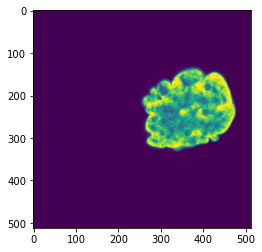

In [59]:
df = pd.read_csv(TRAIN_CSV, index_col=0)
loader = gen_dataloader(df, img_dir='../input/train_cells', bs=1, shuffle=True, aug=None)
aggs_df = grab_pixel_aggs(loader)

In [32]:
aggs_df

# Arg max / 255 (Best fitting's previous solution, unless I missed something in the pipeline)
# Just try the albumentations normalise func to see if it makes more sense?

,blue_mean,blue_std,cell_num,green_mean,green_std,red_mean,red_std
0,tensor(1.4811e-08),tensor(2.2914e-08),0.0,tensor(9.8746e-09),tensor(1.3516e-08),tensor(2.1235e-08),tensor(2.7934e-08)
1,tensor(1.0302e-08),tensor(1.5165e-08),1.0,tensor(1.0665e-08),tensor(1.2035e-08),tensor(1.1370e-08),tensor(1.4084e-08)
2,tensor(5.4478e-09),tensor(9.2786e-09),2.0,tensor(9.7916e-09),tensor(1.3310e-08),tensor(6.8300e-09),tensor(1.0082e-08)
3,tensor(9.7810e-09),tensor(2.3500e-08),3.0,tensor(6.9151e-09),tensor(1.5610e-08),tensor(1.5048e-08),tensor(2.5454e-08)
4,tensor(1.4537e-09),tensor(5.0217e-09),4.0,tensor(4.5399e-09),tensor(1.0254e-08),tensor(2.6117e-09),tensor(6.7321e-09)
5,tensor(3.6413e-09),tensor(1.1667e-08),5.0,tensor(3.8995e-09),tensor(1.1051e-08),tensor(8.7414e-09),tensor(2.1025e-08)
6,tensor(8.9658e-10),tensor(3.1370e-09),6.0,tensor(1.2206e-08),tensor(1.5826e-08),tensor(7.7896e-09),tensor(1.1483e-08)
7,tensor(2.5147e-09),tensor(6.8269e-09),7.0,tensor(3.1701e-09),tensor(5.7236e-09),tensor(3.6773e-09),tensor(7.9907e-09)
8,tensor(6.9819e-09),tensor(1.3585e-08),8.0,tensor(8.3879e-09),tensor(1.4203e-08),tensor(8.5674e-09),tensor(1.9213e-08)
9,tensor(7.6979e-09),tensor(1.0863e-08),9.0,tensor(8.4083e-09),tensor(1.5347e-08),tensor(6.0573e-09),tensor(1.3209e-08)


In [41]:
type(torch.Tensor([1]).item())

float